# Разработка A/B-тестирования и анализ результатов

ТЗ: работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. **Цель-** рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd

In [2]:
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [3]:
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [4]:
sessions_history.groupby('user_id', as_index = False)['session_id'].nunique().sort_values(by = 'session_id', ascending = False).rename(columns={'session_id':'count_session_id'})

,user_id,count_session_id
8948,10E0DEFC1ABDBBE0,10
55627,6A73CB5566BB494D,10
72346,8A60431A825D035B,9
109383,D11541BAC141FB94,9
47956,5BCFE7C4DCC148E9,9
...,...,...
15859,1DF13BB1953B3497,1
51449,628502A3CE7E0A3C,1
15853,1DEEF40DEFBD0C65,1
89905,AC08479B7472C628,1


максимальное количество уникальных сессий(**10**) наблюдается у двух пользователей- `10E0DEFC1ABDBBE0` и `6A73CB5566BB494D`

In [5]:
#Выведите на экран все данные из таблицы sessions_history для одного пользователя с наибольшим количеством сессий.
#Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.
user_max_sessions = sessions_history[sessions_history['user_id'] == '10E0DEFC1ABDBBE0']
user_max_sessions

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


- Пользователь совершил 10 сессий за период с 14 по 25 августа 2025 года.
- Все сессии начались после установки приложения (одна дата install_date).
- Пользователь не зарегистрирован (registration_flag = 0 во всех сессиях).

**Активность**

- Чаще всего просматривал 2 страницы за сессию (5 из 10 случаев).
- Максимальное количество страниц — 4 (в первой и пятой сессиях).
- Сессии обычно происходят днём или вечером (время между 13:00 и 19:00).

In [6]:
# для себя посмотрела второго пользователя с максимальным количеством сессий
user_max_sessions2 = sessions_history[sessions_history['user_id'] == '6A73CB5566BB494D']
user_max_sessions2

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
124515,6A73CB5566BB494D,110E3F28C1F5415F,2025-08-28,2025-08-28 18:58:19,2025-08-28,1,0,3,MENA,Mac
196252,6A73CB5566BB494D,D68C8D98A0F1C439,2025-08-29,2025-08-29 20:53:27,2025-08-28,2,1,3,MENA,Mac
242428,6A73CB5566BB494D,6587D217472BF807,2025-08-30,2025-08-30 13:08:22,2025-08-28,3,1,1,MENA,Mac
304287,6A73CB5566BB494D,A9BC25593D056F8E,2025-09-01,2025-09-01 18:52:49,2025-08-28,4,1,2,MENA,Mac
346611,6A73CB5566BB494D,CB6F9C4191FAF6F6,2025-09-03,2025-09-03 22:49:08,2025-08-28,5,1,3,MENA,Mac
363510,6A73CB5566BB494D,9C609432F6E6535A,2025-09-04,2025-09-04 13:59:46,2025-08-28,6,1,4,MENA,Mac
391902,6A73CB5566BB494D,5D892E33B97A257A,2025-09-06,2025-09-06 18:46:55,2025-08-28,7,1,2,MENA,Mac
404322,6A73CB5566BB494D,22A9BD3861F49087,2025-09-07,2025-09-07 18:33:49,2025-08-28,8,1,3,MENA,Mac
415489,6A73CB5566BB494D,F70E351154B092DC,2025-09-08,2025-09-08 20:30:22,2025-08-28,9,1,4,MENA,Mac
425805,6A73CB5566BB494D,84A3DC0CFF449F53,2025-09-09,2025-09-09 16:36:04,2025-08-28,10,1,1,MENA,Mac


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [7]:
users_and_regusers_by_session_date = sessions_history.groupby('session_date', as_index= False).agg({'user_id':'nunique', 'registration_flag' :'sum'}).rename(columns={
        'user_id': 'unique_users_count',
        'registration_flag': 'registered_users_sum'})
users_and_regusers_by_session_date

,session_date,unique_users_count,registered_users_sum
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840
5,2025-08-16,12205,916
6,2025-08-17,11200,833
7,2025-08-18,10839,860
8,2025-08-19,12118,831
9,2025-08-20,13514,1008


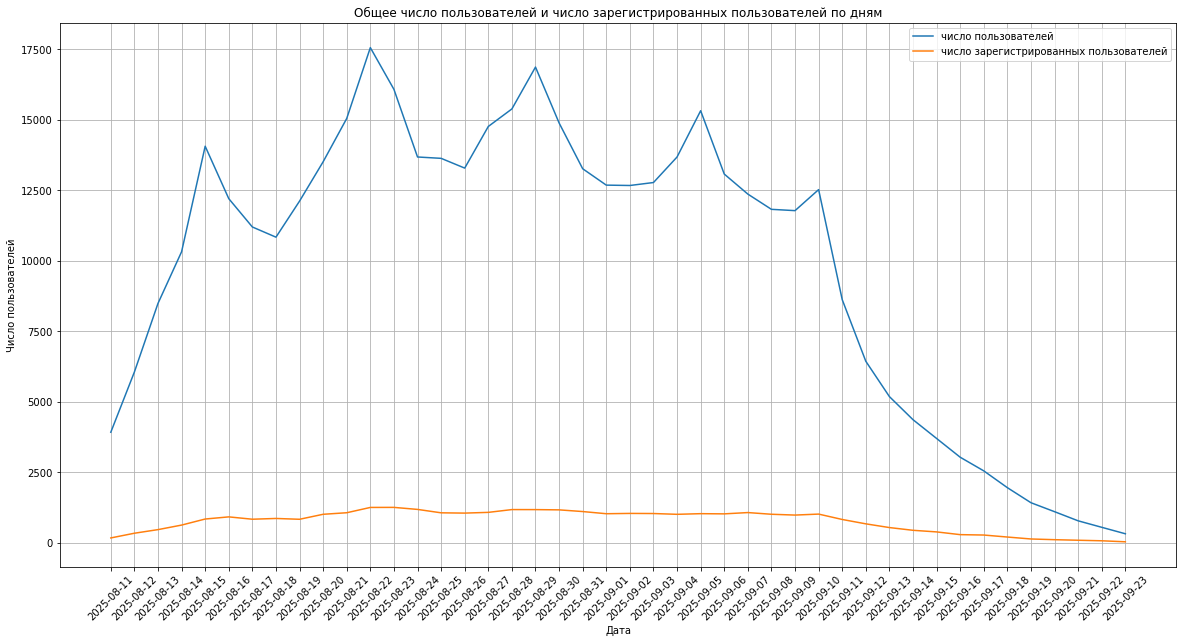

In [8]:
#Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
x= users_and_regusers_by_session_date['session_date']
y_a= users_and_regusers_by_session_date['unique_users_count']
y_b = users_and_regusers_by_session_date['registered_users_sum']
plt.plot(x,y_a, label= 'число пользователей')
plt.plot(x,y_b, label= 'число зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Число пользователей')
plt.title('Общее число пользователей и число зарегистрированных пользователей по дням')
plt.xticks(rotation=45)
plt.grid(True) 
plt.show
plt.legend()

***По графику выше можно сделать вывод о том, что количество зарегестрированных пользователей очень маленькое в течение всего периода по сравнению с общим числом пользователей и также наблюдается одновременное снижение с 10-09-2025 количества как общего числа пользователей, так и зарегестрированных пользователей. в конце рассматриваемого периода на 23-09-2025 г. общее число пользователей составило- 317,а число зарегестрированных- 32***

In [9]:
#рассчитаем доли зарегистрированных пользователей от всех пользователей по дням.
users_and_regusers_by_session_date['share_reg_users']= round(users_and_regusers_by_session_date['registered_users_sum']/ users_and_regusers_by_session_date['unique_users_count'],3)
users_and_regusers_by_session_date

,session_date,unique_users_count,registered_users_sum,share_reg_users
0,2025-08-11,3919,169,0.043
1,2025-08-12,6056,336,0.055
2,2025-08-13,8489,464,0.055
3,2025-08-14,10321,625,0.061
4,2025-08-15,14065,840,0.060
5,2025-08-16,12205,916,0.075
6,2025-08-17,11200,833,0.074
7,2025-08-18,10839,860,0.079
8,2025-08-19,12118,831,0.069
9,2025-08-20,13514,1008,0.075


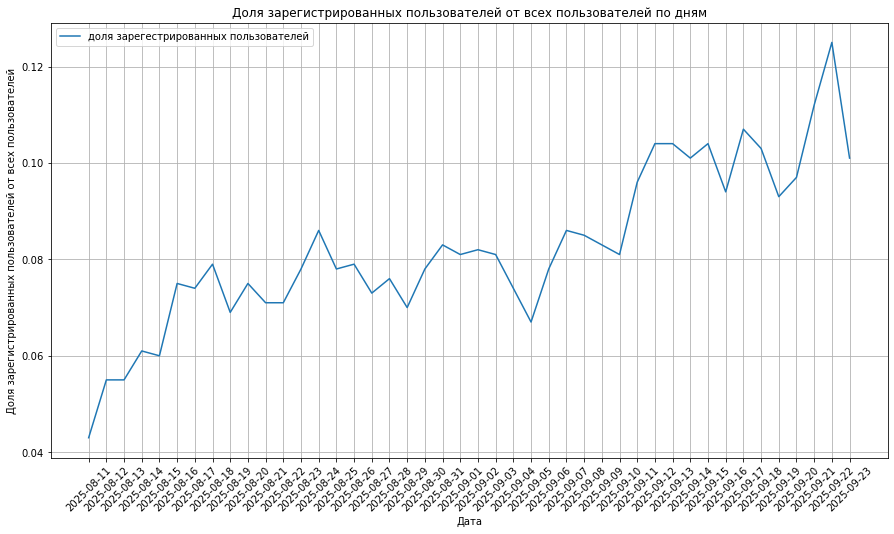

In [10]:
#Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.
plt.figure(figsize=(15,8))
x= users_and_regusers_by_session_date['session_date']
y= users_and_regusers_by_session_date['share_reg_users']
plt.plot(x,y, label = 'доля зарегестрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей от всех пользователей')
plt.title('Доля зарегистрированных пользователей от всех пользователей по дням')
plt.xticks(rotation=45)
plt.grid(True) 
plt.show
plt.legend()

***Глядя на долю зарегестрированных пользователей следует отметить резкие колебания в течение исследуемого периода и особенно резкое увеличение с 17 сентября 2025 года(0,125), а затем резкое снижение после 22 сентября 2025 г.(0,1)***

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [11]:
# количество сессий для каждого значения количества просмотренных страниц
page_count = sessions_history['page_counter'].value_counts().reset_index().rename(columns={'index':'count_pages','page_counter':'sessions_count'})
page_count

,count_pages,sessions_count
0,3,166690
1,4,105569
2,2,105536
3,1,29160
4,5,26288
5,6,2589
6,7,92


<function matplotlib.pyplot.show(close=None, block=None)>

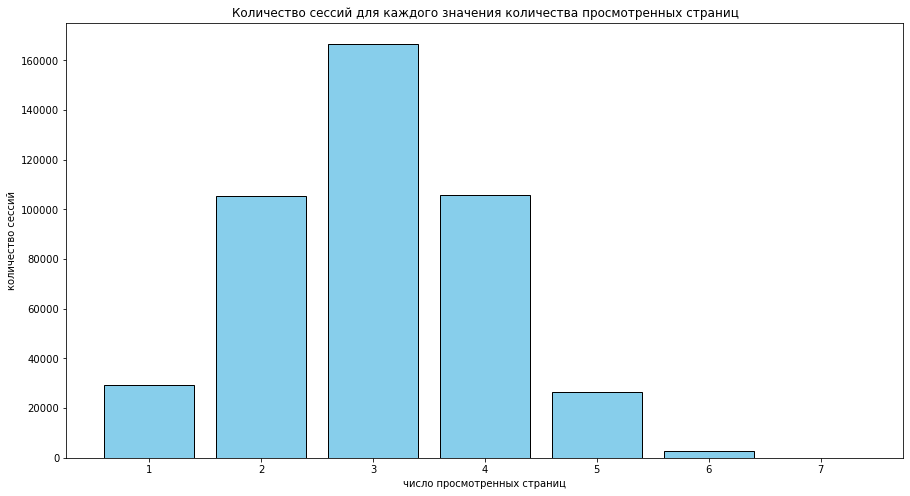

In [12]:
# диаграмма количества сессий для каждого значения количества просмотренных страниц
plt.figure(figsize=(15,8))
x= page_count['count_pages']
y= page_count['sessions_count']
plt.bar(x,y, color='skyblue', edgecolor='black')
plt.xlabel('число просмотренных страниц')
plt.ylabel('количество сессий')
plt.title('Количество сессий для каждого значения количества просмотренных страниц')
plt.show

**По диаграмме выше можно отметить, что большее количество сессий наблюдается при просмотре трех страниц (166 690), примерно на одном и том же уровне по кол-ву сессий находятся количество страниц- 2 и 4**

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [13]:
#создаим собственную функцию для создания столбца good_session
def good_session_func(row):
    if row['page_counter'] >=4:
        return 1
    else:
        return 0
sessions_history['good_session'] = sessions_history.apply(good_session_func,axis=1)
sessions_history

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0
...,...,...,...,...,...,...,...,...,...,...,...
435919,769BC199AF26FEF8,914903B51D69C5EA,2025-09-17,2025-09-17 21:33:57,2025-09-04,3,1,3,CIS,PC,0
435920,599DED39F3CD2ADE,66ADBE343C94DCDA,2025-09-17,2025-09-17 17:11:46,2025-09-04,4,0,4,MENA,iPhone,1
435921,1FA20C4BC94E64B2,C4CCD7E81733665F,2025-09-17,2025-09-17 19:36:55,2025-09-04,4,0,4,CIS,Android,1
435922,88E5FC3016A7A0AD,6834FB4914B56200,2025-09-17,2025-09-17 22:13:33,2025-09-04,5,0,4,MENA,PC,1


In [14]:
#среднее значение доли успешных сессий ко всем сессиям по дням за весь период наблюдения
good_session_frame= sessions_history.groupby('session_date', as_index=False).agg({'session_id':'count', 'good_session' :'sum'}).rename(columns={'session_id':'sessions_count','good_session' :'good_session_count'})
good_session_frame['good_session_share'] = round(good_session_frame['good_session_count']/ good_session_frame['sessions_count'],2)
good_session_frame

,session_date,sessions_count,good_session_count,good_session_share
0,2025-08-11,3919,1226,0.31
1,2025-08-12,6056,1829,0.30
2,2025-08-13,8489,2604,0.31
3,2025-08-14,10321,3262,0.32
4,2025-08-15,14065,4289,0.30
5,2025-08-16,12205,3737,0.31
6,2025-08-17,11200,3557,0.32
7,2025-08-18,10839,3366,0.31
8,2025-08-19,12118,3791,0.31
9,2025-08-20,13514,4148,0.31


In [15]:
good_session_mean = round(good_session_frame['good_session_share'].mean(),2)
good_session_mean

0.31

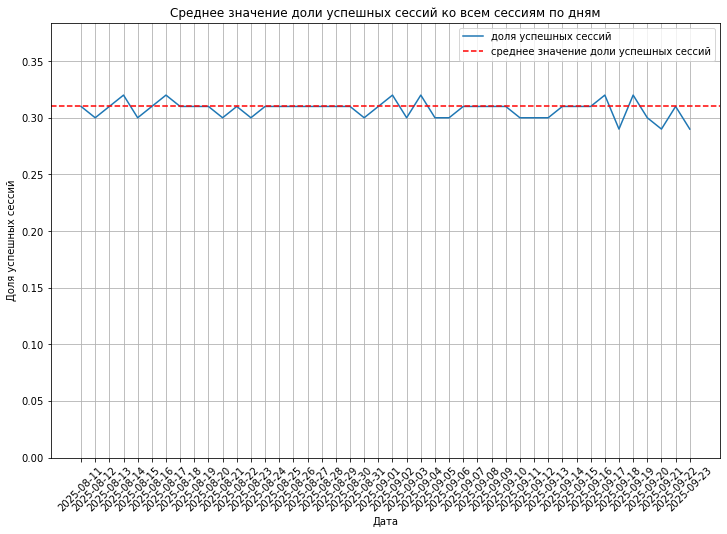

In [16]:
#график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.
fig, ax = plt.subplots(figsize=(12, 8))
x= good_session_frame['session_date']
y= good_session_frame['good_session_share']
plt.plot(x,y, label = 'доля успешных сессий')
plt.axhline(y= good_session_mean, color='red', linestyle='--', label='среднее значение доли успешных сессий')
ax.set_ylim(0, max(good_session_frame['good_session_share']) * 1.2)
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.title('Среднее значение доли успешных сессий ко всем сессиям по дням')
plt.xticks(rotation=45)
plt.grid(True) 
plt.show
plt.legend()

Среднее значение доли успешных сессий ко всем сессиям по дням равно 0,31 и следует отметить, что отклонение успешных сессий совсем небольшое: диапазон значений находится от 0,29 до 0,32. Однако на конец исследуемого периода следует отметить снижение доли успешных сессий с 0,31 до 0,29. 

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [17]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1-beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [18]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round(users_and_regusers_by_session_date['unique_users_count'].mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [19]:
sessions_test_part= pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')
sessions_test_part.tail()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
3125,02A3BA5F727BC3C9,7D4427384463A16E,2025-10-14,2025-10-14 14:52:26,2025-10-14,1,0,4,MENA,Android,B
3126,A7E51F39427F03A5,290910138655DD03,2025-10-14,2025-10-14 19:15:18,2025-10-14,1,0,2,CIS,PC,B
3127,78DDBD077D61EEDB,C10E073BFF1FAF0C,2025-10-14,2025-10-14 16:07:20,2025-10-14,1,0,2,EU,iPhone,B
3128,B44E0A30E8ED1AFC,7B404F7021711E5D,2025-10-14,2025-10-14 17:41:01,2025-10-14,1,0,3,EU,Mac,B
3129,C9F3E29E5168D642,A42ED6D173E5EE2D,2025-10-14,2025-10-14 19:18:11,2025-10-14,1,0,3,CIS,PC,A


In [20]:
# количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения- 14-10-2025
users_count_by_test_group = sessions_test_part.groupby(['test_group','session_date'])['user_id'].nunique().reset_index().rename(columns={'user_id':'users_count'})
display(users_count_by_test_group)

,test_group,session_date,users_count
0,A,2025-10-14,1477
1,B,2025-10-14,1466


In [21]:
users_count_A = users_count_by_test_group[users_count_by_test_group['test_group']== 'A']['users_count'].values[0]
users_count_B = users_count_by_test_group[users_count_by_test_group['test_group']== 'B']['users_count'].values[0]
display(users_count_A)
display(users_count_B)

1477

1466

In [22]:
#процентная разница в количестве пользователей в группах A и B
prcnt_diff= round(abs(users_count_A-users_count_B)*100/users_count_A,2)
print(f'процентная разница в количестве пользователей в группах A и B составляет за первый день тестирования {prcnt_diff}%')

процентная разница в количестве пользователей в группах A и B составляет за первый день тестирования 0.74%


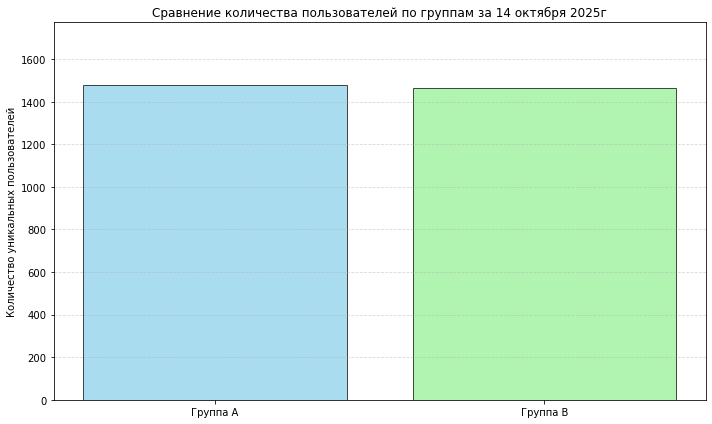

In [23]:
# визуализация различия в группах A и B
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(['Группа A', 'Группа B'], [users_count_A, users_count_B], 
        color=['skyblue', 'lightgreen'], alpha=0.7, edgecolor='black')
ax.set_ylim(0, max([users_count_A, users_count_B]) * 1.2)
plt.title('Сравнение количества пользователей по группам за 14 октября 2025г')
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

За первый день тестирования наблюдается незначительная разница между двумя группами- 0,74%, значит группы А и В распределены примерно одинаково- то есть сопоставимы

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [24]:
#количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет
A= sessions_test_part[sessions_test_part['test_group']=='A']['user_id']
B= sessions_test_part[sessions_test_part['test_group']=='B']['user_id']
intersection= list(set(A)&set(B))
intersection

[]

Список пересечений оказался пустым а значит данные в двух группах независимы

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [25]:
#распределение пользователей по типам устройства в двух группах
device_type_A = sessions_test_part[sessions_test_part['test_group']=='A'].groupby(['test_group','device'])['user_id'].nunique().reset_index().rename(columns={'user_id':'users_count'})
device_type_A['share_device_A'] = round(device_type_A['users_count']/ device_type_A['users_count'].sum(),2)

device_type_B = sessions_test_part[sessions_test_part['test_group']=='B'].groupby(['test_group','device'])['user_id'].nunique().reset_index().rename(columns={'user_id':'users_count'})
device_type_B['share_device_B'] = round(device_type_B['users_count']/ device_type_B['users_count'].sum(),2)
display(device_type_A)
display(device_type_B)

,test_group,device,users_count,share_device_A
0,A,Android,656,0.44
1,A,Mac,156,0.11
2,A,PC,369,0.25
3,A,iPhone,296,0.20


,test_group,device,users_count,share_device_B
0,B,Android,668,0.46
1,B,Mac,148,0.10
2,B,PC,381,0.26
3,B,iPhone,269,0.18


In [26]:
# распределение пользователей по регионам в двух группах
region_A = sessions_test_part[sessions_test_part['test_group']=='A'].groupby(['test_group','region'])['user_id'].nunique().reset_index().rename(columns={'user_id':'users_count'})
region_A['share_region_A'] = round(region_A['users_count']/ region_A['users_count'].sum(),2)

region_B = sessions_test_part[sessions_test_part['test_group']=='B'].groupby(['test_group','region'])['user_id'].nunique().reset_index().rename(columns={'user_id':'users_count'})
region_B['share_region_B'] = round(region_B['users_count']/ region_B['users_count'].sum(),2)
display(region_A)
display(region_B)

,test_group,region,users_count,share_region_A
0,A,CIS,644,0.44
1,A,EU,224,0.15
2,A,MENA,609,0.41


,test_group,region,users_count,share_region_B
0,B,CIS,645,0.44
1,B,EU,217,0.15
2,B,MENA,604,0.41


<function matplotlib.pyplot.show(close=None, block=None)>

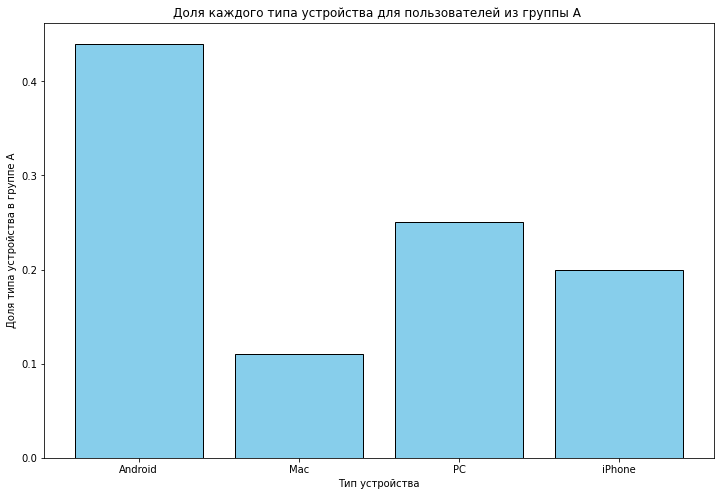

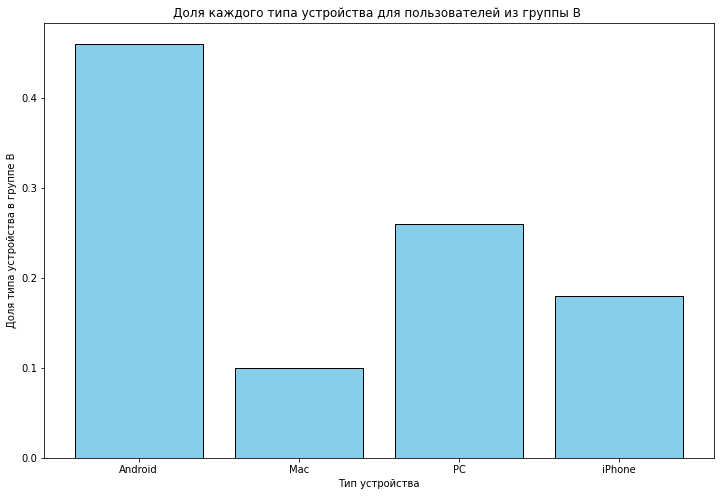

In [27]:
# две диаграммы:доля каждого типа устройства для пользователей из группы A 
# доля каждого типа устройства для пользователей из группы B
plt.figure(figsize=(12,8))
x= device_type_A['device']
y= device_type_A['share_device_A']
plt.bar(x,y, color='skyblue', edgecolor='black')
plt.xlabel('Тип устройства')
plt.ylabel('Доля типа устройства в группе А')
plt.title('Доля каждого типа устройства для пользователей из группы A ')


plt.figure(figsize=(12,8))
x= device_type_B['device']
y= device_type_B['share_device_B']
plt.bar(x,y, color='skyblue', edgecolor='black')
plt.xlabel('Тип устройства')
plt.ylabel('Доля типа устройства в группе B')
plt.title('Доля каждого типа устройства для пользователей из группы B ')
plt.show

Глядя на распределение долей по типам устройств в двух группах, можно сделать вывод о том, что распределения двух групп совпадают

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


<function matplotlib.pyplot.show(close=None, block=None)>

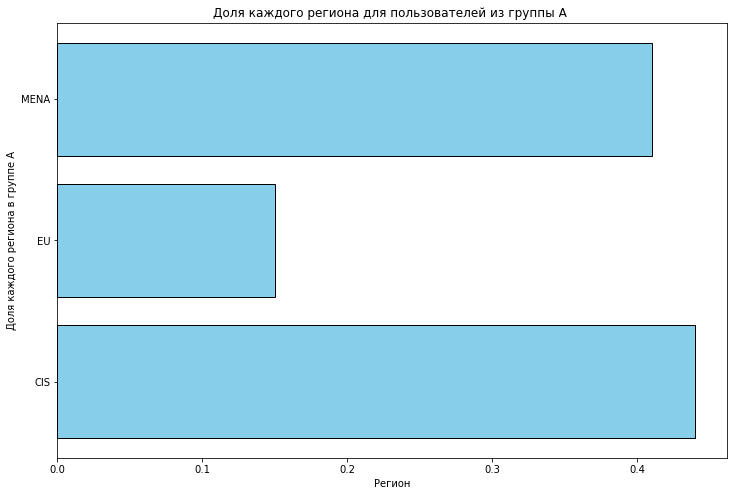

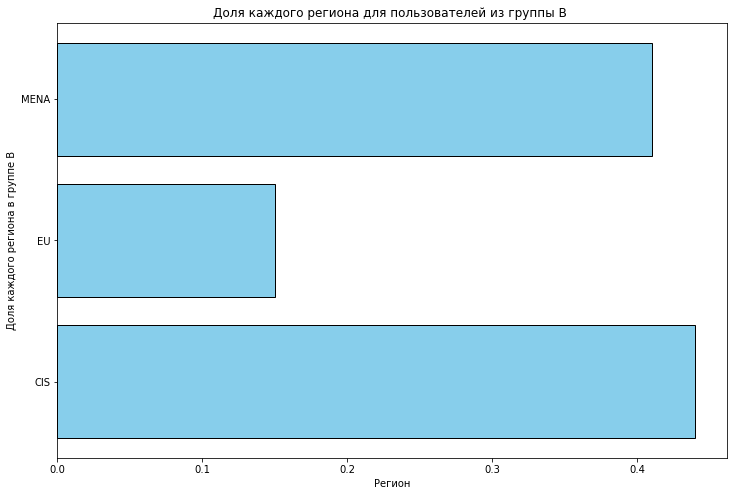

In [28]:
# две диаграммы:доля каждого региона для пользователей из группы A,
# доля каждого региона для пользователей из группы B.
plt.figure(figsize=(12,8))
x= region_A['region']
y= region_A['share_region_A']
plt.barh(x,y, color='skyblue', edgecolor='black')
plt.xlabel('Регион')
plt.ylabel('Доля каждого региона в группе А')
plt.title('Доля каждого региона для пользователей из группы A ')


plt.figure(figsize=(12,8))
x= region_B['region']
y= region_B['share_region_B']
plt.barh(x,y, color='skyblue', edgecolor='black')
plt.xlabel('Регион')
plt.ylabel('Доля каждого региона в группе B')
plt.title('Доля каждого региона для пользователей из группы B ')
plt.show

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.


- различие в количестве пользователей в двух группах совсем незначительное -0,74% - такая разница допустима.
- Список пересечений оказался пустым а значит данные в двух группах независимы
- Глядя на распределения долей по типам устройств и регионам в двух группах, можно сделать вывод о том, что распределения двух групп совпадают 

Исходя из выводов выше, можно сказать о том, что A/B-тест проходит корректно

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [29]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')
sessions_test['good_session'] = sessions_test.apply(good_session_func,axis=1)
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [30]:
#количество уникальных сессий для каждого дня и обеих тестовых групп
users_count_by_groups = sessions_test.groupby(['session_date','test_group'], as_index=False)['session_id'].nunique().rename(columns={'session_id':'sessions_count'})
users_count_by_groups

,session_date,test_group,sessions_count
0,2025-10-14,A,1502
1,2025-10-14,B,1628
2,2025-10-15,A,2235
3,2025-10-15,B,2283
4,2025-10-16,A,3280
5,2025-10-16,B,3241
6,2025-10-17,A,4089
7,2025-10-17,B,4054
8,2025-10-18,A,5013
9,2025-10-18,B,5059


Сформулируем гипотезу:
- H0: среднее значение дневнных сессий не различается в двух выборках
- H1:среднее значение дневнных сессий различается в двух выборках

In [31]:
from scipy import stats as st
from scipy.stats import ttest_ind
metric_A_sessions= users_count_by_groups[users_count_by_groups['test_group']=='A']['sessions_count']
metric_B_sessions= users_count_by_groups[users_count_by_groups['test_group']=='B']['sessions_count']

alpha = 0.05
test_result_1 = ttest_ind(metric_A_sessions,metric_B_sessions, alternative = 'two-sided', equal_var=False)
display(test_result_1.pvalue)
if test_result_1.pvalue > alpha:
    print(f'Нулевая гипотеза о равенстве среднего количества сессий в двух группах не может быть опровергнута')
else:
    print(f'Нулевая гипотеза о равенстве среднего количества сессий в двух группах опровергается')


0.9382195854082714

Нулевая гипотеза о равенстве среднего количества сессий в двух группах не может быть опровергнута


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [32]:
good_session_share_by_group= sessions_test.groupby(['test_group']).agg({'session_id': 'nunique', 'good_session' :'sum'}).reset_index()
good_session_share_by_group['good_session_share'] = good_session_share_by_group['good_session'] / good_session_share_by_group['session_id']
good_session_share_by_group

,test_group,session_id,good_session,good_session_share
0,A,49551,15248,0.307723
1,B,50454,16059,0.318290


In [33]:
share_good_A= sessions_test[sessions_test['test_group']=='A']['good_session'].mean()
share_good_B= sessions_test[sessions_test['test_group']=='B']['good_session'].mean()

diff_key_metric= round(abs(share_good_A-share_good_B)*100,2)
print(f' разница долей успешных сессий в двух группах составляет {diff_key_metric}%')

 разница долей успешных сессий в двух группах составляет 1.06%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

Сформулируем гипотезу:
- H0: долей успешных сессий в двух группах значимо не различается в двух выборках
- H1:долей успешных сессий в двух группах значимо различается в двух выборках

In [34]:
# используем z-тест пропорций для долевой ключевой метрики
from statsmodels.stats.proportion import proportions_ztest
alpha = 0.05
m_a = sessions_test[sessions_test['test_group']=='A']['good_session'].sum()
m_b = sessions_test[sessions_test['test_group']=='B']['good_session'].sum()
n_a = sessions_test[sessions_test['test_group']=='A'].shape[0]
n_b= sessions_test[sessions_test['test_group']=='B'].shape[0]
p_a= m_a/n_a 
p_b =m_b/n_b
ztest_result, p_value = proportions_ztest([m_a,m_b],[n_a,n_b], alternative='two-sided')
display(p_value)
if p_value > alpha:
    print(f'Нулевая гипотеза о том что, доли успешных сессий в двух группах значимо не различается в двух выборках, не может быть опровергнута')
else:
    print(f'Нулевая гипотеза о том что, доли успешных сессий в двух группах значимо не различается в двух выборках,  опровергается')




0.0003149479976072246

Нулевая гипотеза о том что, доли успешных сессий в двух группах значимо не различается в двух выборках,  опровергается


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

### Вывод по результатам A/B-эксперимента

#### **Характеристики проведённого эксперимента:**
- **Количество задействованных пользователей:** В тесте участвовало около 100 000 пользователей (49 551 в группе A и 50 454 в группе B).  
- **Длительность эксперимента:** Тест проводился с 14 октября по 2 ноября 2025 года (20 дней).  

#### **Влияние нового алгоритма рекомендаций на ключевую метрику:**  
Ключевая метрика — **доля успешных сессий** (просмотр 4 и более страниц за сессию):  
- В группе A: **30.77%**.  
- В группе B: **31.83%**.  
- **Разница между группами:** **1.06%** в пользу группы B.  

#### **Статистическая значимость:**  
- **Значение p-value:** **0.0003** (меньше уровня значимости 0.05).  
- **Вывод:** Различие в долях успешных сессий между группами **статистически значимо**.  

#### **Рекомендация:**  
Новый алгоритм рекомендаций **увеличил долю успешных сессий на 1.06%**, и этот эффект подтверждён статистически. Однако:  
 **Эффект небольшой** (1.06%), что может не оправдать затрат на внедрение.  


**Итоговое решение:**  
- **Внедрять алгоритм** можно, если его реализация не требует значительных ресурсов.  
- **Рекомендуется** провести дополнительный анализ влияния на другие метрики перед окончательным решением.  

**Примечание:**  
- Тест проведён корректно: группы сопоставимы по размеру, распределению устройств/регионов, отсутствуют пересечения пользователей.   

**Заключение:** Новый алгоритм показал статистически значимое улучшение, но его практическая ценность требует дополнительной оценки.